In [1]:
import numpy as np
import sdt.sim
from matplotlib import pyplot
import tifffile
import io
import hdf5plugin
import time

In [2]:
def simulate_image(image_size=256, beads=200, sigma=2, amp=500, zrange=12, offset=100, poisson=True):
    coords = np.random.randint(0,image_size, size=(3,beads)).T # z x y
    
    out = np.zeros(
        shape=(image_size,image_size,image_size),
        #dtype=np.uint16
    )
    
    for i in range(image_size):
        filtered_coords = []
        for x in coords:
            if i-(zrange) < x[0] < i+(zrange):
                filtered_coords.append(x)
        
        to_plot = []
        for coord in filtered_coords:
            dz = abs(coord[0] - i)
            #The below ratio is G(x) / G(0) (normalize)
            ratio = np.exp(-1 * (dz**2) / (2 * (sigma**2)))
            to_plot.append( ((coord[1], coord[2]), amp * ratio) )
        
        if len(to_plot) > 0:
            new_coords = np.array( [ [x,y] for ((x,y),_) in to_plot ] )
            new_amplitudes = np.array( [amp for _,amp in to_plot] )

            out[i,...] = sdt.sim.simulate_gauss(
                (image_size,image_size),
                new_coords,
                new_amplitudes,
                np.zeros_like(new_amplitudes)+sigma
            )[...]
    
    out += offset
    
    if poisson:
        return np.random.poisson(lam=out).astype(np.uint16)
    
    return out.astype(np.uint16)

In [3]:
%%timeit
img = simulate_image()

864 ms ± 27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
tifffile.imwrite('stack.tif', simulate_image(beads=10000))

In [5]:
import h5py

In [6]:
def test_compression(img, params={}, cs=(32,32,32)):
    with io.BytesIO() as tmpfile:
        with h5py.File(tmpfile, 'w') as h5file:
            #img = simulate_image(beads=beads)
            h5file.create_dataset("data", data=img, **params, chunks=cs)
            return tmpfile.getbuffer().nbytes

In [7]:
def ratio(beads = 200, params={}, bg_sub=0):
    img = simulate_image(beads=beads)
    
    # upsample, bg subtract, then downsample to prevent roundoff errors
    if bg_sub > 0:
        img = img.astype(np.int64)
        img -= bg_sub
        img[ img < 0 ] = 0
        img = img.astype(np.uint16)
        
    start_time = time.time()
    uncompressed = test_compression(img)
    compressed = test_compression(img, params=params)
    return 1.0 * uncompressed / compressed, time.time()-start_time

In [8]:
ratio( params={'compression':'gzip', 'compression_opts':5} )

(2.1365080039555737, 1.61580491065979)

In [9]:
ratio( params=hdf5plugin.Blosc(cname='zstd', clevel=9, shuffle=hdf5plugin.Blosc.BITSHUFFLE) )

(2.579842548086709, 2.0142409801483154)

In [21]:
x_marks = [10**i for i in range(0,5)]
print(x_marks)

res = [
    ratio( params=hdf5plugin.Blosc(cname='zstd', clevel=9, shuffle=hdf5plugin.Blosc.BITSHUFFLE), beads=b)[0]
    for b in x_marks
]

res2 = [
    ratio( params={'compression':'gzip', 'compression_opts':5}, beads=b)[0]
    for b in x_marks
]

res3 = [
    ratio( params={'compression':'gzip', 'compression_opts':5}, beads=b, bg_sub = 150)[0]
    for b in x_marks
]

[1, 10, 100, 1000, 10000]


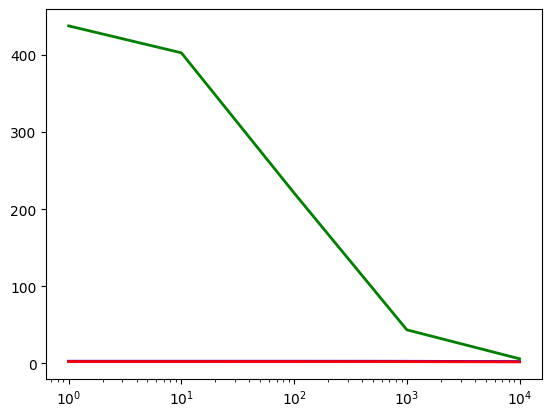

In [22]:
fig = pyplot.figure()
ax = fig.add_subplot(1, 1, 1)

line, = ax.plot(x_marks, res, color='blue', lw=2)
line, = ax.plot(x_marks, res2, color='red', lw=2)
line, = ax.plot(x_marks, res3, color='green', lw=2)

ax.set_xscale('log')

In [23]:
import seaborn as sns

(array([1.300000e+01, 1.070000e+02, 3.950000e+02, 2.747000e+03,
        7.910000e+03, 3.683700e+04, 7.771500e+04, 2.555320e+05,
        5.869440e+05, 7.756600e+05, 1.595851e+06, 1.614910e+06,
        2.541599e+06, 2.002515e+06, 2.463452e+06, 1.955618e+06,
        1.062195e+06, 9.211300e+05, 4.021400e+05, 2.850170e+05,
        1.009200e+05, 5.924300e+04, 2.026600e+04, 5.327000e+03,
        2.440000e+03, 4.980000e+02, 1.940000e+02, 3.500000e+01,
        2.000000e+00, 4.000000e+00]),
 array([ 52.        ,  55.56666667,  59.13333333,  62.7       ,
         66.26666667,  69.83333333,  73.4       ,  76.96666667,
         80.53333333,  84.1       ,  87.66666667,  91.23333333,
         94.8       ,  98.36666667, 101.93333333, 105.5       ,
        109.06666667, 112.63333333, 116.2       , 119.76666667,
        123.33333333, 126.9       , 130.46666667, 134.03333333,
        137.6       , 141.16666667, 144.73333333, 148.3       ,
        151.86666667, 155.43333333, 159.        ]),
 <BarContainer

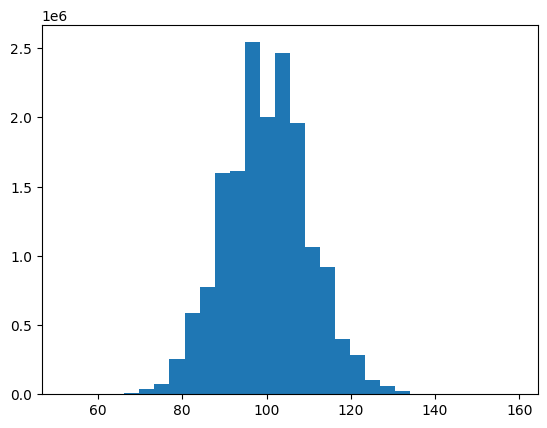

In [24]:
pyplot.hist( simulate_image(beads=0).ravel(), bins=30 )